# Structural Bioinformatics - Binding Pocket Challenge 2025

## Viktor Doychev (K12441809)

This is my solution for the Binding Pocket challenge 2025 in the AI Master's course *Structural Bioinformatics* at JKU Linz.

# Workflow

1. **Data Exploration** 

    To visualize the proteins I installed UCSF ChimeraX 1.9 from source. With a bit of manipulations of the PDB files one could also visualize the provided bindingpocket residues from the train.csv.
    
    In total we've got 16379 PDBs in train and 3064 PDBs in test dataset (to be predicted for the submission).

    The train.csv file contained the residues formatted like "chain_resid" and each row was linked to a protein via the "id". A few proteins had residues with additional information "xx", formatted like "chain_resid_xx"
    
    Below I analyzed how many of the proteins had the additional information residues.


2. **Data Preparation**

    PDB files were collected with their relative paths in a dataset for further modelling.

3. **Baseline**

    I decided to use P2Rank due to it's robustness and simplicity. The result was quite good, so I committed to improving the model as you can later see.
    
    Used scripts:

    - `my_metric.py`
    - `format_submissions.py`
    - `most_probable.py` 


4. **Evaluation**

    After local evaluation on the training set, I uploaded my predictions to the challenge server.


5. **Further Experiments**

    I wanted to finetune the RF model of P2Rank on our training dataset using it's internal functions. However, this attempt remains to be continued in future experiments


### Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import argparse
import re 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score


# 1. Data Exploration

In [ ]:
# Function to count proteins with additional values in a row
def count_specials(row):
    try:
        residues = row.split()    
    except:
        print(row)
        return 0
    return sum(1 for residue in residues if re.match(r'^[A-Za-z]+_\d+_.+', residue))

# Apply to the column
df['special_count'] = df['resid'].apply(count_specials)

# Result 1: how many rows have at least one special value
rows_with_specials = (df['special_count'] > 0).sum()

# Result 2: counts per row
counts_per_row = df['special_count'].tolist()

print("Proteins that have residues with additional info:", rows_with_specials)

nan
nan
nan
nan
Proteins that have residues with additional info: 682


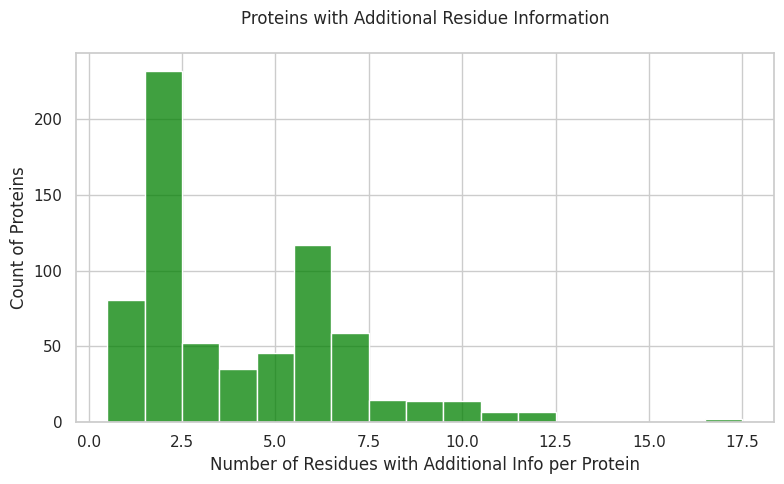

In [ ]:
df_specials = df[df["special_count"]!=0].copy()
df_specials.reset_index(drop=True, inplace=True)

# Assuming df['special_count'] already exists
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

sns.histplot(data=df_specials, x='special_count', bins=range(df['special_count'].max() + 2), discrete=True, color="green")

plt.title("Proteins with Additional Residue Information\n")
plt.xlabel("Number of Residues with Additional Info per Protein")
plt.ylabel("Count of Proteins")
plt.tight_layout()
plt.show()


Out of 16379 in the training set there were 682 proteins with additional information on some of the residues.

# 2. Data Preparation

In this step I created a dataset file with the paths to all ".pdb" files. It can be used for predictions with the internal command `predict` of P2Rank.

In [ ]:
# Change these paths as needed
# This was used to prepare a dataset for both train and test sets
# input_dir = "/home/exvick/Desktop/Structural_Bioinformatics/Protein_Bindingpocket_challenge/data/train"
# output_file = "all_train_pdb_files.csv"
input_dir = "/home/exvick/Desktop/Structural_Bioinformatics/Protein_Bindingpocket_challenge/data/test"
output_file = "all_test_pdb_files.csv"

# Collect full paths of .pdb files
pdb_paths = [
    os.path.join(input_dir, f)
    for f in sorted(os.listdir(input_dir))
    if f.endswith(".pdb")
]

# Write paths to output file
with open(output_file, "w") as f:
    for path in pdb_paths:
        f.write(path + "\n")

In [ ]:
# Save a ds format for the test set
df = pd.read_csv("all_test_pdb_files.csv")
df.to_csv("whole_test_dataset.ds", index=False)

Then I split the train set to Train/Validation/Test in 60/20/20 for further finetuning:

In [ ]:
# Load the full training dataset
df = pd.read_csv("all_train_pdb_files.csv")

# Shuffle the rows (optional for random split)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

total = len(df)
train_end = int(0.6 * total)
val_end = int(0.8 * total)

# Split into train, validation, and test
df_train = df.iloc[:train_end]
df_val = df.iloc[train_end:val_end]
df_test = df.iloc[val_end:]

# Save to ds files
df.to_csv("whole_train_dataset.ds", index=False)
df_train.to_csv("train_dataset.ds", index=False)
df_val.to_csv("validation_dataset.ds", index=False)
df_test.to_csv("test_dataset.ds", index=False)

print(f"Total entries: {total}")
print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")

# 3. Baseline

To make predictions I first tested P2Rank on the whole training dataset:

`./prank predict  ../whole_train_dataset.ds -o ../predictions -visualizations 0 -threads 8`

To format the predictions as the given sample_submission.csv I created a `format_submissions.py` script (please refer to it). The script aggregates the P2Rank predictions from multiple files to one csv file which is saved in a given directory and can filter predicted residues based on their probabilities with a threshold-argument:

`
python ../format_submission.py -i /home/exvick/Desktop/Structural_Bioinformatics/Protein_Bindingpocket_challenge/data/output/1_alphafold -o /home/exvick/Desktop/Structural_Bioinformatics/Protein_Bindingpocket_challenge/submissions/2_submission.csv -t 0.7
`

Then I made an local evaluation with `my_metric.py` (please refer to it) which was adapted from the provided `metric.py`. This resulted in a jaccard score of **0.471**.

# 4. Evaluation

To make predictions on the test set (for submissions) again I used the P2Rank internal function:

`./prank predict  ../whole_test_dataset.ds -o ../predictions -visualizations 0 -threads 8`


Using the configuration "alphafold" I got those results:

- All pockets:

    jaccard score = 0.186

- Probability threshold >0.7:

    jaccard score = 0.197
    
- Probability threshold >0.6:

    jaccard score = 0.209


Using default P2Rank configuration:
    
- All pockets:

    jaccard score = 0.199
    
- Probability threshold >0.4:

    jaccard score = 0.228
    
- Only most probable residues (first row of the predictions):

    **jaccard score = 0.261**

For the last approach of taking the most probable prediction the script `most_probable.py` was used in an identical way to `format_submission.py` to collect only the first row of predicted residues:

`python most_probable.py -i /home/exvick/Desktop/Structural_Bioinformatics/Protein_Bindingpocket_challenge/data/output/2_default -o /home/exvick/Desktop/Structural_Bioinformatics/Protein_Bindingpocket_challenge/submissions/6_submission.csv 
`

# 5. Further Experiments

### Finetuning P2Rank RF Model (unsuccessful)

For this first the residues had to be formatted as ligands. Then the internal `traineval` function of P2Rank could be used to train on predicting bindingpockets. Unfortunately, I couldn't figure out how to save the trained model and due to lack of time this section was left for future experiments.

In [ ]:
def create_lig_files_from_dataframe(df, output_directory):
    """
    Generates .lig files for each protein in the DataFrame.

    Args:
        df (pd.DataFrame):          DataFrame with 'id' and 'resid' columns.
        output_directory (str):     The path to the directory where .lig files will be saved.
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        print(f"Created directory: {output_directory}")

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        protein_id = row['id']
        residue_string = row['resid']
        
        try:
            # Split the long string of residues into a list of individual "Chain_ResidueID" strings
            residue_list = residue_string.split()
        except:
            print(residue_string)

        # Format the content for the .lig file
        # Each "Chain_ResidueID" is split into "Chain ResidueID" and put on a new line
        lig_content = ""
        for res in residue_list:
            # The format is ChainID_ResidueID, so we replace the underscore with a space
            parts = res.split('_')
            if len(parts) == 2:
                chain_id = parts[0]
                residue_id = parts[1]
                lig_content += f"{chain_id} {residue_id}\n"

        # Define the output filename
        output_filename = f"{protein_id}_protein.pdb.lig"
        output_filepath = os.path.join(output_directory, output_filename)

        # Write the formatted content to the .lig file
        try:
            with open(output_filepath, 'w') as f:
                f.write(lig_content)
            print(f"Successfully created: {output_filepath}")
        except IOError as e:
            print(f"Error writing file {output_filepath}: {e}")

In [ ]:
# 1. Read the df with train residues
df = pd.read_csv("./data/train.csv")

# 2. Specify the directory where you want to save the .lig files
output_dir = "./data/train"

# 3. Run the function
create_lig_files_from_dataframe(df, output_dir)

In [ ]:
def create_training_pdbs(original_pdb_dir, lig_dir, output_pdb_dir):
    """
    Modifies PDB files for P2Rank training.

    This script converts specified binding site residues from ATOM to HETATM
    records AND renames them to a single residue name ("LIG"). This makes the
    entire binding site appear as a single, cohesive ligand molecule, which
    prevents P2Rank's internal filtering from discarding it as irrelevant.

    Args:
        original_pdb_dir (str): Directory containing the original PDB files.
        lig_dir (str):          Directory containing the corresponding .lig files.
        output_pdb_dir (str):   Directory where the modified PDBs will be saved.
    """
    if not os.path.exists(output_pdb_dir):
        os.makedirs(output_pdb_dir)
        print(f"Created output directory: {output_pdb_dir}")

    # Process every .lig file in the directory
    for lig_filename in os.listdir(lig_dir):
        if not lig_filename.endswith(".lig"):
            continue

        # Construct corresponding PDB filename
        pdb_filename = lig_filename.replace('.lig', '')
        original_pdb_path = os.path.join(original_pdb_dir, pdb_filename)
        lig_filepath = os.path.join(lig_dir, lig_filename)
        output_pdb_path = os.path.join(output_pdb_dir, pdb_filename)

        if not os.path.exists(original_pdb_path):
            print(f"Warning: Could not find matching PDB for {lig_filename}. Skipping.")
            continue

        # --- 1. Read the binding site residues from the .lig file ---
        binding_site_residues = set()
        try:
            with open(lig_filepath, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        # Store as a tuple: (ChainID, ResidueNumber)
                        binding_site_residues.add((parts[0], parts[1]))
        except IOError as e:
            print(f"Error reading {lig_filepath}: {e}")
            continue
            
        if not binding_site_residues:
            print(f"Warning: No residues found in {lig_filepath}. Skipping.")
            continue

        # --- 2. Modify the PDB file ---
        modified_pdb_lines = []further
        try:
            with open(original_pdb_path, 'r') as f_pdb:
                for line in f_pdb:
                    # We only care about ATOM records
                    if line.startswith("ATOM  "):
                        # Extract chain ID and residue number from the PDB line
                        chain_id = line[21].strip()
                        res_num = line[22:26].strip()

                        # Check if this atom belongs to a binding site residue
                        if (chain_id, res_num) in binding_site_residues:
                            # It's a match! Change ATOM to HETATM and residue name to LIG.
                            # This makes the entire binding site appear as one molecule.
                            modified_line = "HETATM" + line[6:17] + "LIG" + line[20:]
                            modified_pdb_lines.append(modified_line)
                        else:
                            # Not part of the binding site, keep it as is
                            modified_pdb_lines.append(line)
                    else:
                        # Keep all other lines (like existing HETATM, CONECT, etc.) as they are
                        modified_pdb_lines.append(line)
        except IOError as e:
            print(f"Error reading {original_pdb_path}: {e}")
            continue

        # --- 3. Write the new PDB file ---
        try:
            with open(output_pdb_path, 'w') as f_out:
                f_out.writelines(modified_pdb_lines)
            print(f"Successfully created modified PDB: {output_pdb_path}")
        except IOError as e:
            print(f"Error writing file {output_pdb_path}: {e}")


In [ ]:
# 1. Define your directories
# Directory with your original PDBs (e.g. 0_protein.pdb)
original_pdbs = "/home/exvick/Desktop/Structural_Bioinformatics/Protein_Bindingpocket_challenge/data/train"

# Directory with your .lig files (e.g. 0_protein.pdb.lig)
lig_files = "/home/exvick/Desktop/Structural_Bioinformatics/Protein_Bindingpocket_challenge/data/train"

# Directory where the NEW PDBs for training will be saved
training_pdbs_output = "/home/exvick/Desktop/Structural_Bioinformatics/Protein_Bindingpocket_challenge/data/train_modified"


# 2. Run the function
create_training_pdbs(original_pdbs, lig_files, training_pdbs_output)

The RF model was trained with this command in the terminal:

`./prank traineval -t ../train_dataset.ds -e ../validation_dataset.ds -o ../finetuning -visualizations 0 -threads 8`